In [1]:
%matplotlib inline

import numpy as np
import scipy.linalg as spl
import matplotlib.pyplot as plt

import sys
sys.path.append('../code')
sys.path.append('../code/opt')
import gpr as gp
import kernel as ks
import adam

from scipy.optimize import minimize, approx_fprime, check_grad

In [2]:
run ../code/tests/kerneltest.py

In [3]:
kern = ks.SquareExponential(np.array([1., 0.4]))#np.array([1., 3., 0.4, 0.4]))
p0 = kern.p.copy()

In [4]:
test, mygrad, testgrad = testKernelGrad(kern, eps = 1E-8)
print(test)

[True, True]


In [9]:
x_obs = np.arange(-3,3,0.5)
x_obs += np.random.randn(len(x_obs))*0.05
x_obs = np.sort(x_obs)
noise = 0.2

K = kern(x_obs, x_obs) + noise**2*np.eye(x_obs.shape[0])
y_obs = np.random.multivariate_normal(np.zeros_like(x_obs), K)

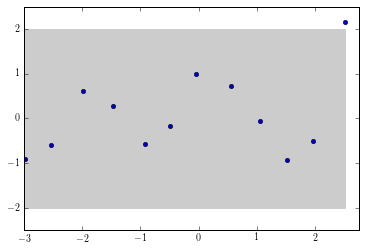

In [10]:
plt.scatter(x_obs, y_obs)
plt.fill_between(x_obs, -2, 2, color='k', alpha=0.2,);
plt.xlim([-3, 3-0.25]); plt.ylim([-2.5, 2.5]);

In [11]:
mygpr = gp.GPR(kern)

In [12]:
x_test = np.linspace(-3,3,50)
mean, var = mygpr.fit_transform(y_obs, x_obs, noise**2, x_test)

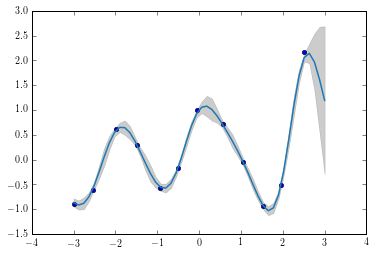

In [13]:
plt.plot(x_test, mean)
plt.scatter(x_obs, y_obs)
plt.fill_between(x_test, mean-2*var.diagonal(), 
                 mean+2*var.diagonal(), alpha=0.2, color='k')

In [15]:
testposp = ks.Kernel.getargp(np.r_[mygpr.kernel.p, noise**2])
print(approx_fprime(testposp, mygpr.logmarg, 1E-6))
print(mygpr.grad_logmarg(testposp))

[-0.60261559  2.18049056 -0.16366535]
[-0.60261475  2.18049058 -0.16366528]


In [16]:
check_grad(mygpr.logmarg, mygpr.grad_logmarg, testposp)

2.727718137418551e-07

In [17]:
logpvar0 = ks.Kernel.getargp(np.r_[p0, noise**2])# + np.random.randn(mygpr.kernel.N_p+1)*0.1)
logsol = minimize(mygpr.nll_dnll, logpvar0, jac= True, method='l-bfgs-b')
bestpvar = np.exp(logsol['x'])
print(logsol)
print(bestpvar)

      fun: 13.506901473209654
 hess_inv: <3x3 LbfgsInvHessProduct with dtype=float64>
      jac: array([ -1.40736923e-06,  -5.82682410e-06,   1.15869556e-06])
  message: 'CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL'
     nfev: 31
      nit: 26
   status: 0
  success: True
        x: array([  1.23017091,  -0.23385331, -16.30191313])
[  3.42181429e+00   7.91477909e-01   8.32087664e-08]


In [19]:
a, l = ks.Kernel.getargp(p0)
pa = np.arange(a-4, a+4, 0.1)
pl = np.arange(l-3, l+3, 0.1)
plist = [[aa, ll] for ll in pl for aa in pa]
logmargs = [mygpr.logmarg(np.r_[p, ks.Kernel.getargp(noise**2)]) for p in plist]
x, y = np.meshgrid(pa, pl)

(-3.7096329315889278, 2.1903670684110779)

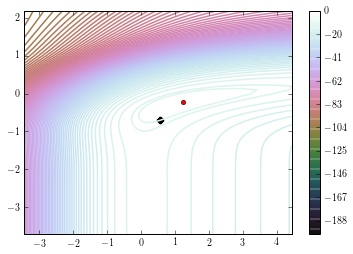

In [30]:
truelogmar = mygpr.logmarg(ks.Kernel.getargp(np.r_[p0, noise**2]))-1E-8

plt.contour(x, y, np.array(logmargs).reshape(len(pl),len(pa)), 
            levels=np.sort(np.r_[np.arange(-200,1,1), truelogmar]),
            cmap = 'cubehelix');plt.colorbar()
plt.scatter(a, l, marker = 'x', lw = 5, c = 'k')
plt.scatter(logsol['x'][0], logsol['x'][1], c = 'r')
plt.xlim([pa.min(), pa.max()])
plt.ylim([pl.min(), pl.max()])

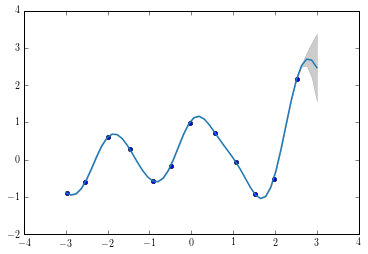

In [23]:
mygpr.logmarg(logsol['x'])
maxmean, maxvar = mygpr.transform(x_test)
plt.plot(x_test, maxmean)
plt.scatter(x_obs, y_obs)
plt.fill_between(x_test, maxmean-2*maxvar.diagonal(), 
                 maxmean+2*maxvar.diagonal(), alpha=0.2, color='k')